In [1]:
!pip install captum
# Common imports
import numpy as np
import pandas as pd
import os
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import collections
from torch.utils.data import Dataset, DataLoader
from skimage import io
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch
import torch.nn.functional as F

import urllib
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
import pandas as pd
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import confusion_matrix
    
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:0000:010:01


In [2]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [3]:
model = nn.Sequential(collections.OrderedDict([
          ('conv1', nn.Conv2d(3, 20, 3,padding=1)), 
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(20, 64, 3, padding=1)),
          ('relu2', nn.ReLU()),
          ('flatten', nn.Flatten()),
          ('fc1', nn.Linear(640000, 512)), 
          ('relu1', nn.ReLU()),
          ('fc_2', nn.Linear(512, 128)), 
          ('relu2', nn.ReLU()), 
          ('fc3', nn.Linear(128, 4)), 
        ]))



class Net(nn.Module):
    def __init__(self, l1=512, l2=128):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(20, 64, 3)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(147456, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 4)
    
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [4]:
model

Sequential(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=640000, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

Defining a custom dataset class to return image and label

In [4]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
    
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image,label


In [5]:
#transform function to transform the images

train_transforms = transforms.Compose([
transforms.RandomRotation(degrees=10),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225])
])


In [6]:
cancer_train_dataset = MyDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train', transform = train_transforms )
cancer_test_dataset =  MyDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/example.csv',
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test', transform = train_transforms)

In [7]:
len(cancer_test_dataset)

5041

In [37]:
cancer_train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [7]:
cancer_test_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ...,  1.9920,  2.0263, -2.1179],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.9064,  1.8722, -2.1179],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.7523,  1.6495, -2.1179],
          ...,
          [-2.1179,  2.2489,  2.2489,  ...,  2.1462,  2.1633,  2.2318],
          [-2.1179,  2.2489,  2.2489,  ...,  1.9920,  2.0434,  2.1975],
          [-2.1179,  2.1975,  2.2489,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ...,  0.9930,  1.0280, -2.0357],
          [ 2.0609,  2.1485,  2.1835,  ...,  0.9405,  0.9230, -2.0357],
          [ 2.0609,  2.1660,  2.2710,  ...,  0.8004,  0.7304, -2.0357],
          ...,
          [-2.0357,  1.9559,  1.8859,  ...,  1.6933,  1.7458,  1.8683],
          [-2.0357,  1.7633,  1.7458,  ...,  1.4657,  1.5707,  1.7633],
          [-2.0357,  1.5182,  1.7108,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ...,  1.9777,  2.0648, -1.8044],
          [ 2.5180,  2.5877,

In [8]:
#Splitting the dataset into training and validation sets
trainset = cancer_train_dataset
test_abs = int(len(trainset) * 0.8)
train_set, val_set = random_split(
    trainset, [test_abs, len(trainset) - test_abs])

In [9]:
#setting up the different types of dataloaders for each dataset
testDataLoader = DataLoader(cancer_test_dataset, batch_size=16,
                        shuffle=False)
trainDataLoader = DataLoader(train_set, batch_size=16,
                        shuffle=True) 
valDataLoader = DataLoader(val_set, batch_size=16,
                        shuffle=True)

In [10]:
#defining the training loop 
import datetime
import matplotlib.pyplot as plt
import torch

epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    model.train()
    losses = []
    accuracies = []
    for epoch in range(n_epochs):
        loss_train = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
        
        accuracy_train = correct / total
        accuracies.append(accuracy_train)
        losses.append(loss_train / len(train_loader))
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}, Training accuracy {}'.format(
                datetime.datetime.now(), epoch, losses[-1], accuracy_train))
    print("training completed")
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


2023-03-27 11:48:19.412222 Epoch 0, Training loss 0.723730024493774, Training accuracy 0.7256613756613757
2023-03-27 11:48:52.178022 Epoch 1, Training loss 0.48662901750074633, Training accuracy 0.8093915343915344
2023-03-27 11:49:23.980409 Epoch 2, Training loss 0.44332391518241004, Training accuracy 0.825
2023-03-27 11:49:55.663412 Epoch 3, Training loss 0.4231538407614821, Training accuracy 0.830952380952381
2023-03-27 11:50:27.537319 Epoch 4, Training loss 0.4073791723485729, Training accuracy 0.8395502645502646
2023-03-27 11:50:59.109919 Epoch 5, Training loss 0.3964839504114165, Training accuracy 0.8443121693121693
2023-03-27 11:51:31.065479 Epoch 6, Training loss 0.3858945610407291, Training accuracy 0.8474867724867725
2023-03-27 11:52:03.047502 Epoch 7, Training loss 0.37411906585947907, Training accuracy 0.8494708994708995
2023-03-27 11:52:35.245483 Epoch 8, Training loss 0.3616872601541858, Training accuracy 0.8556878306878307
2023-03-27 11:53:07.381897 Epoch 9, Training loss

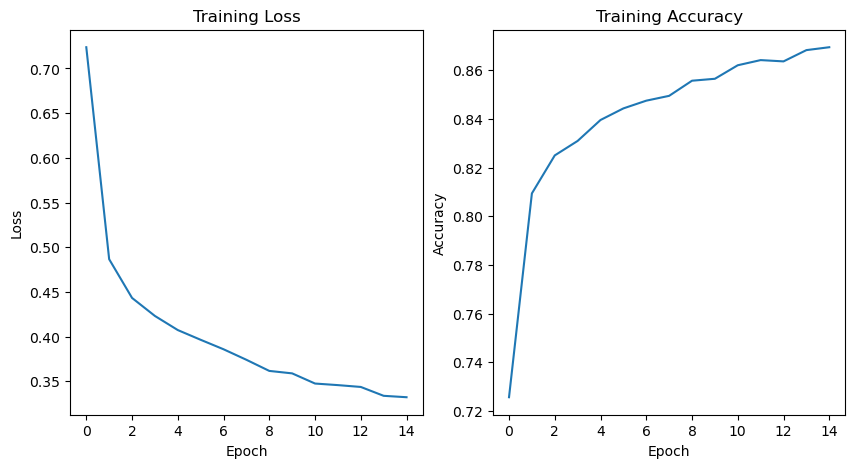

In [12]:
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

n_epochs = 15

# train the CNN
training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device =  device,
    loss_fn = loss_fn,
    train_loader = trainDataLoader,
)

In [11]:

def test_loop(model, device, test_loader):
    solution = []
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #solution.append(int(pred.cpu()[0][0].numpy()))
            solution.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return solution

In [12]:
# validation loop so that we can get the accuracy on the validation dataset
def val_loop(model, device, test_loader):
    predictions = []
    true = []
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #solution.append(int(pred.cpu()[0][0].numpy()))
            predictions += pred.cpu().numpy().tolist()
            true += target.cpu().numpy().tolist()
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    
    conf_matrix = confusion_matrix(true, predictions)
    print(conf_matrix)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return predictions

In [15]:
testDataLoader = DataLoader(cancer_test_dataset, batch_size=16,
                        shuffle=True) # num_workers=0 ?

In [15]:
#Lets run a test loop on our validation set and print the accuracy and print the 
#confusion matrix.
accuracy = val_loop(model = model, device = device, test_loader = valDataLoader)

[[ 69  71   0  13]
 [ 30 661   3  27]
 [  1   3 122  16]
 [  3  19   3 471]]

Test set: Average loss: 0.3370, Accuracy: 1323/1512 (88%)



Correctly Classified instances of each class:

1. Class 0 - 69
2. Class 1 - 661
3. Class 2 - 122
4. Class 3 - 471

* Class 0 has the lowest number of correctly classified instances
* Class 1 has the highest number of correctly classified instances
* Class 0 has the highest number of misclassifications
* The model is able to work well with classes 1,2 and 3.
* There is confusion between classes 0 and 1 with 71 instances of clas 0 being misclassified as class 1.


Validation accuracy of this model is pretty decent. Now let us get the labels in example.csv and upload it to kaggle to check the accuracy on test set.

In [21]:
#Now lets run a test lopp on our test set.
submission = test_loop(model = model, device = device, test_loader = testDataLoader)


Test set: Average loss: 4.9532, Accuracy: 323/5041 (6%)



In [22]:
#submission
sol = [item.item() for sublist in submission for item in sublist]

In [23]:
solution = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')
solution.shape

(5041, 2)

In [24]:
solution['Label'] = sol
solution.head(20)

,Filename,Label
0,10001.png,3
1,10002.png,3
2,10003.png,2
3,10004.png,3
4,10005.png,3
5,10006.png,3
6,10007.png,2
7,10008.png,2
8,10009.png,2
9,10010.png,3


In [25]:
solution.to_csv('solution_5L_v.csv', index=False)

Upon uploading this custom CNN model, the accuracy on the test set came out to be 86%, which is decent. Now let us try using raytune to fine tune this model and try to get an even higher accuracy.

# Using Ray-Tune on the model

In [39]:
#load data function 
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    
    cancer_train_dataset = MyDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train', transform = train_transforms )
    cancer_test_dataset =  MyDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/example.csv',
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test', transform = train_transforms)
    
    return cancer_train_dataset, cancer_test_dataset

In [40]:
#training function
def train_model(config, checkpoint_dir=None):
    net = Net(config["l1"], config["l2"])
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    #set loss function and optimiser
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    
    #load the data
    trainset, testset = load_data()

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = DataLoader(train_subset, batch_size=int(config["batch_size"]),
                        shuffle=True) 
    valloader = DataLoader(val_subset, batch_size=int(config["batch_size"]),
                        shuffle=True) 

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [41]:
#test function to test the model and download the prediction as a csv file.
def test_accuracy(net, device="cuda:0"):
    labels_list = []
    trainset, testset = load_data()

    testloader = DataLoader(testset, batch_size=4,
                        shuffle=False) 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            labels_list.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            percent = correct / total
    
    labs = [item.item() for sublist in labels_list for item in sublist]
    solution = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')
    solution['Label'] = labs
    solution.to_csv('solution_tuned_custom', index=False)
    return labs

Now lets define the main class for ray tune and call it.

In [43]:
def main(num_samples=2, max_num_epochs=10, gpus_per_trial=1):
  #  data_dir = os.path.abspath("./data")
    load_data()
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_model),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    temp = test_accuracy(best_trained_model, device)
#    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=2, max_num_epochs=7, gpus_per_trial=1)

== Status ==
Current time: 2023-03-27 17:57:40 (running for 00:00:00.17)
Memory usage on this node: 3.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/6.04 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_model_2023-03-27_17-57-40
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+-----------------+--------------+------+------+-------------|
| train_model_dd96e_00000 | RUNNING  | 172.19.2.2:1636 |            4 |   64 |  256 | 0.00357959  |
| train_model_dd96e_00001 | PENDING  |                 |            8 |  128 |   32 | 0.000173042 |
+-------------------------+----------+-----------------+---

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_dd96e_00000,0.843254,2023-03-27_18-00-31,True,,99ae2f52a535473cb5e8debfc8cb9e11,15ae11af8f5e,7,0.41421,172.19.2.2,1636,True,166.464,23.1475,166.464,1679940031,0,,7,dd96e_00000,0.00748205
train_model_dd96e_00001,0.833995,2023-03-27_18-01-26,True,,011b75451ea04b3180e00e0713c67180,15ae11af8f5e,2,0.446782,172.19.2.2,1823,True,50.1243,24.4177,50.1243,1679940086,0,,2,dd96e_00001,0.00649476


== Status ==
Current time: 2023-03-27 17:58:16 (running for 00:00:36.75)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.8510904500566462
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/6.04 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_model_2023-03-27_17-57-40
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc             |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+-----------------+--------------+------+------+-------------+---------+------------+----------------------|
| train_model_dd96e_00000 | RUNNING  | 172.19.2.2:1636 |            4 |   64 |  256 | 0.00357959  | 0.8510

2023-03-27 18:01:26,375	INFO tune.py:763 -- Total run time: 226.24 seconds (226.09 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 18:01:26 (running for 00:03:46.11)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.4717772335144223 | Iter 2.000: -0.4420811854199403 | Iter 1.000: -0.8336238867785565
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/6.04 GiB heap, 0.0/3.02 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_model_2023-03-27_17-57-40
Number of trials: 2/2 (2 TERMINATED)
+-------------------------+------------+-----------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc             |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-----------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_model_dd96e_00000 | TERMINATED | 172.19.2.2:1636 |            4 |   64 

Since our base model has a little bit higher accuracy (88%) than the raytune model (84%), we will stick to our custom CNN and use those values as our final labels.

# Pre-trained Model

In [27]:
modelres = models.resnet18(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [31]:
modelres

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
for param in modelres.parameters():
    param.requires_grad = False
num_ftrs = modelres.fc.in_features
modelres.fc = nn.Linear(num_ftrs, 4)


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelres.parameters(), lr=0.001)
num_epochs = 15
#loss_fn = nn.CrossEntropyLoss()

2023-03-27 11:56:08.959917 Epoch 0, Training loss 0.9307145856903672, Training accuracy 0.6579365079365079
2023-03-27 11:56:25.837212 Epoch 1, Training loss 0.7189452705499234, Training accuracy 0.7445767195767196
2023-03-27 11:56:42.565541 Epoch 2, Training loss 0.655933042094269, Training accuracy 0.7616402116402117
2023-03-27 11:56:59.562442 Epoch 3, Training loss 0.625313827779782, Training accuracy 0.7736772486772486
2023-03-27 11:57:16.396287 Epoch 4, Training loss 0.6001980041978727, Training accuracy 0.7814814814814814
2023-03-27 11:57:33.485424 Epoch 5, Training loss 0.5813534810792568, Training accuracy 0.7925925925925926
2023-03-27 11:57:50.033332 Epoch 6, Training loss 0.559697651018804, Training accuracy 0.7994708994708994
2023-03-27 11:58:07.579512 Epoch 7, Training loss 0.5568287772998749, Training accuracy 0.8006613756613756
2023-03-27 11:58:24.388485 Epoch 8, Training loss 0.5420932890748876, Training accuracy 0.8013227513227513
2023-03-27 11:58:41.431411 Epoch 9, Trai

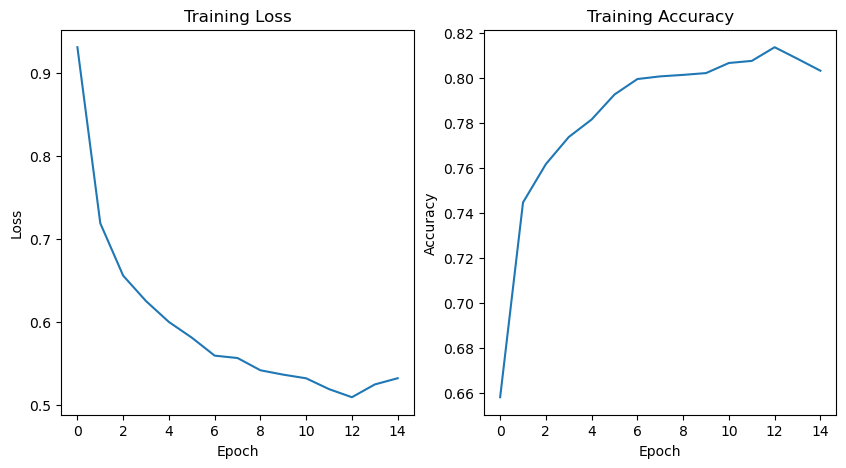

In [19]:
modelres.train()
training_loop(
    n_epochs = num_epochs, 
    optimizer = optimizer,
    model = modelres, 
    device =  device,
    loss_fn = criterion,
    train_loader = trainDataLoader,
)


In [8]:
solution = []
solution2 = []
def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
   #         pred = output.argmax(dim=1, keepdim=True)
            _, pred = torch.max(output.data, 1)
            # get the index of the max log-probability
#            solution2.append(int(pred.cpu()[0][0].numpy()))
            solution2.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return solution2

In [20]:
accuracy2 = val_loop(model = modelres, device = device, test_loader = valDataLoader)

[[ 58  76   1  18]
 [ 21 667   5  28]
 [  0  11 120  11]
 [  8  43  20 425]]

Test set: Average loss: 0.4688, Accuracy: 1270/1512 (84%)



Correctly classified instances:

* Class 0 - 58
* Class 1 - 667
* Class 2 - 120
* Class 3 - 425


Looking at this confusion matrix we can say the following:
1. Class 1 has the most number of correctly classified images. ( looking at the diagonal from top left to bottom right )
2. Class 0 has the least numnber of correctly classified images.
3. Class 0 also has the highest number of misclassifications.
4. By looking at the matrix we can say that the model works well with classes 1,2 and 3 but has some problem in classifying class 0. 
5. The model misclassified 76 instances of class 0 as class 1 which points out that there is some confusion in classifying these two classes. This may be due to the fact that the data may not be equally distributed among the classes.
6. Class 0 has some overlap with class 1 and class 3. 

We are getting a validation accuracy of 84%. Lets check how much accuracy we get after uploading the results on kaggle.

In [26]:
submission2 = test_loop(model = modelres, device = device, test_loader = testDataLoader)


Test set: Average loss: 3.4773, Accuracy: 280/5041 (6%)



In [27]:
sub = [item.item() for sublist in submission2 for item in sublist]

In [28]:
solution2 = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')
solution2.shape

(5041, 2)

In [29]:
solution2['Label'] = sub
solution2.head(20)

,Filename,Label
0,10001.png,3
1,10002.png,1
2,10003.png,3
3,10004.png,1
4,10005.png,1
5,10006.png,3
6,10007.png,2
7,10008.png,1
8,10009.png,2
9,10010.png,3


**Upon submitting this baseline resnet model, we get an accuracy of 84% on the training set.**

In [30]:
solution2.to_csv('solution2_resnet_v.csv', index=False)

# Now lets try using ray tune on the resnet model

In [18]:
def res():
    return modelres

In [14]:
def train_model(config, checkpoint_dir=None):
    net = res()
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data()

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = DataLoader(train_subset, batch_size=int(config["batch_size"]),
                        shuffle=True) #num_workers=0 ?
    valloader = DataLoader(val_subset, batch_size=int(config["batch_size"]),
                        shuffle=True) # num_workers=0 ?

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

Now we will define the main clas and run it.
Note: Due to limited resources, we will reduce the parameters of raytune. 

In [20]:
def main(num_samples=2, max_num_epochs=10, gpus_per_trial=1):
  #  data_dir = os.path.abspath("./data")
    load_data()
    config = {
#         "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
#         "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_model),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=2, max_num_epochs=10, gpus_per_trial=1)

2023-03-27 15:57:35,939	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (42 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-03-27 15:57:36,832	WARNING util.py:244 -- The `start_trial` operation took 1.525 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:57:36 (running for 00:00:03.09)
Memory usage on this node: 2.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.09 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_model_2023-03-27_15-57-33
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+-------------+
| Trial name              | status   | loc            |   batch_size |          lr |
|-------------------------+----------+----------------+--------------+-------------|
| train_model_163c3_00000 | RUNNING  | 172.19.2.2:802 |           16 | 0.000367518 |
| train_model_163c3_00001 | PENDING  |                |            8 | 0.000332129 |
+-------------------------+----------+----------------+--------------+-------------+


== Status ==
Current time: 2

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_163c3_00000,0.801587,2023-03-27_16-00-49,True,,baff69cf06134820bc79db8f7e78fac7,85c56052b5b4,10,0.501481,172.19.2.2,802,True,187.239,18.7092,187.239,1679932849,0,,10,163c3_00000,0.00495648
train_model_163c3_00001,0.725529,2023-03-27_16-01-19,True,,958eaf7666fa4360914e2211feec7e0c,85c56052b5b4,1,0.707719,172.19.2.2,1005,True,24.0548,24.0548,24.0548,1679932879,0,,1,163c3_00001,0.00556421


== Status ==
Current time: 2023-03-27 15:58:08 (running for 00:00:34.93)
Memory usage on this node: 4.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6442687480073226
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.09 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_model_2023-03-27_15-57-33
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+-------------+----------+------------+----------------------|
| train_model_163c3_00000 | RUNNING  | 172.19.2.2:802 |           16 | 0.000367518 | 0.644269 |   0.763228 |                    1

2023-03-27 16:00:49,938	WARNING util.py:244 -- The `start_trial` operation took 0.543 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 16:00:54 (running for 00:03:21.20)
Memory usage on this node: 2.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.5457775089301561 | Iter 4.000: -0.5560396039172223 | Iter 2.000: -0.5799393942481593 | Iter 1.000: -0.6442687480073226
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.09 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_model_2023-03-27_15-57-33
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+-------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_model_163c3_00001 | RUNNING    | 172.19.2.2:1005 |            8 

2023-03-27 16:01:19,151	INFO tune.py:763 -- Total run time: 226.37 seconds (225.28 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 16:01:19 (running for 00:03:45.30)
Memory usage on this node: 4.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.5457775089301561 | Iter 4.000: -0.5560396039172223 | Iter 2.000: -0.5799393942481593 | Iter 1.000: -0.6759937102127062
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.09 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_model_2023-03-27_15-57-33
Number of trials: 2/2 (2 TERMINATED)
+-------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_model_163c3_00000 | TERMINATED | 172.19.2.2:802  |           16 | 0.000367518 |

**As you can see, the accuracy after using raytune comes out to be 80% which is a bit lower than our original test accuracy of 84.5% and validation accuracy of 83%. Hence, we will use the predictions of our original resnet model.**

In [38]:
testDataLoader = DataLoader(cancer_test_dataset, batch_size=1,
                        shuffle=False) 

# Lets apply captum on the custom model 

**Note: I will be stopping the output before it reaches completion as the output is too large and it will crash the notebook.**

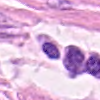

In [34]:
img = Image.open("/kaggle/input/deep-learning-for-msc-2022-23/test/10001.png")

img

We will now use captum on this image.


Integrated Gradients




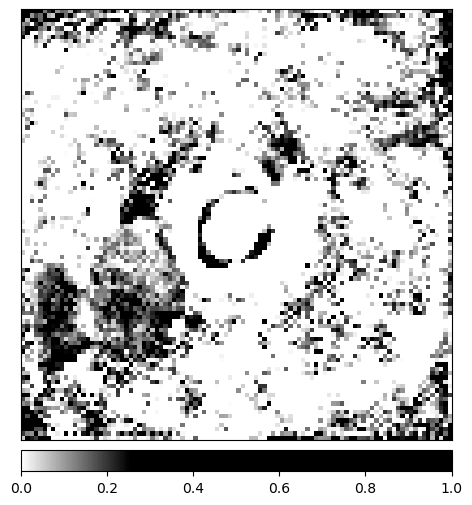

Noise Tunnel




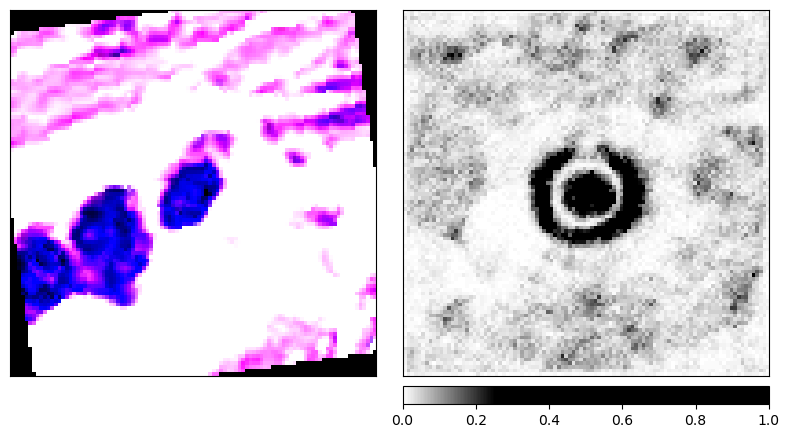

Gradient Shap




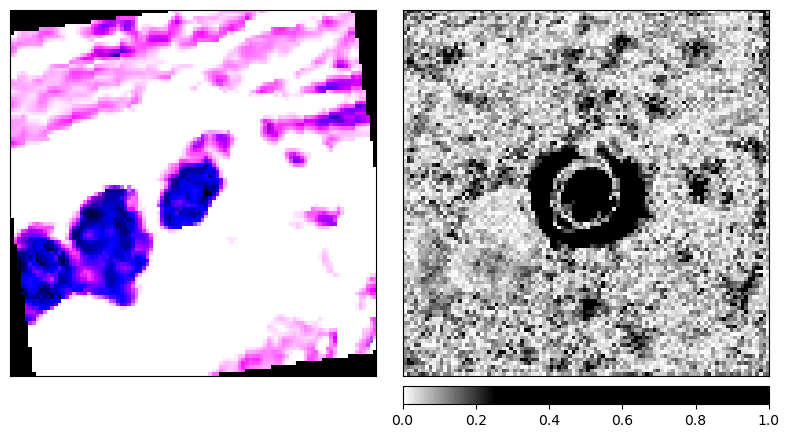

Occlusion




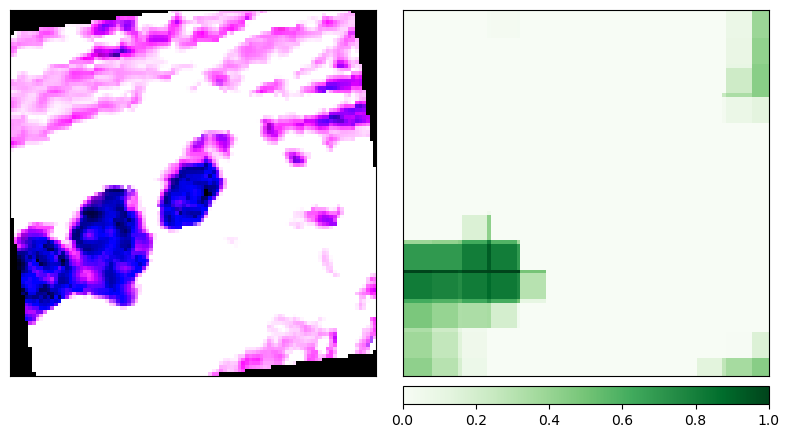

In [39]:
 with torch.no_grad():
        for data, target in testDataLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = F.softmax(output, dim=1)
            
            print("Integrated Gradients")
            print("\n")
            integrated_gradients = IntegratedGradients(model)
            attributions_ig = integrated_gradients.attribute(data, target=pred_label_idx, n_steps=200)
            
            default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
            _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(data.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
            
            print("Noise Tunnel")
            print("\n")
            
            noise_tunnel = NoiseTunnel(integrated_gradients)

            attributions_ig_nt = noise_tunnel.attribute(data, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
            _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(data.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
            
            torch.manual_seed(0)
            np.random.seed(0)
            
            print("Gradient Shap")
            print("\n")
            gradient_shap = GradientShap(model)

            # Defining baseline distribution of images
            rand_img_dist = torch.cat([data * 0, data * 1])

            attributions_gs = gradient_shap.attribute(data,
                                                      n_samples=50,
                                                      stdevs=0.0001,
                                                      baselines=rand_img_dist,
                                                      target=pred_label_idx)
            _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                  np.transpose(data.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                  ["original_image", "heat_map"],
                                                  ["all", "absolute_value"],
                                                  cmap=default_cmap,
                                                  show_colorbar=True)
            
            print("Occlusion")
            print("\n")
            occlusion = Occlusion(model)

            attributions_occ = occlusion.attribute(data,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
            
            _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(data.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
            break

Note that the image is flipped due to the transformation function.

It looks like captum is able to identify the three cells.
It is also able to identify something circular, which may be an outline of the cell. Therefore, it is able to identify the edges of the cell

Noise tunnel and Gradient shap are able to identify the cell however, occlusion output seems incomprehensible.

# Now lets apply captum on the resnet model

Integrated Gradients




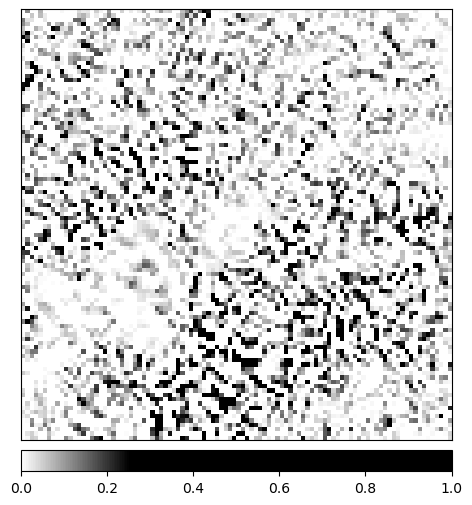

Noise Tunnel




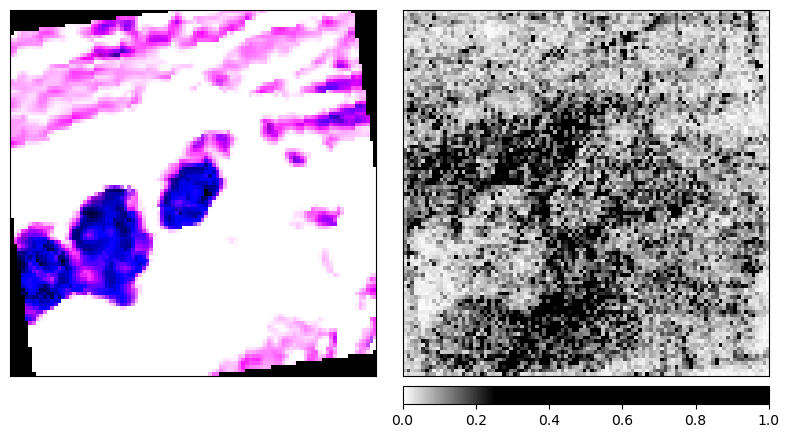

Gradient Shap




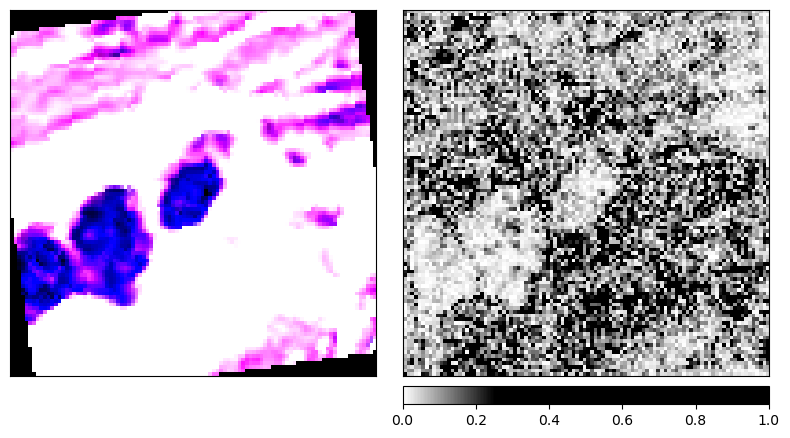

Occlusion




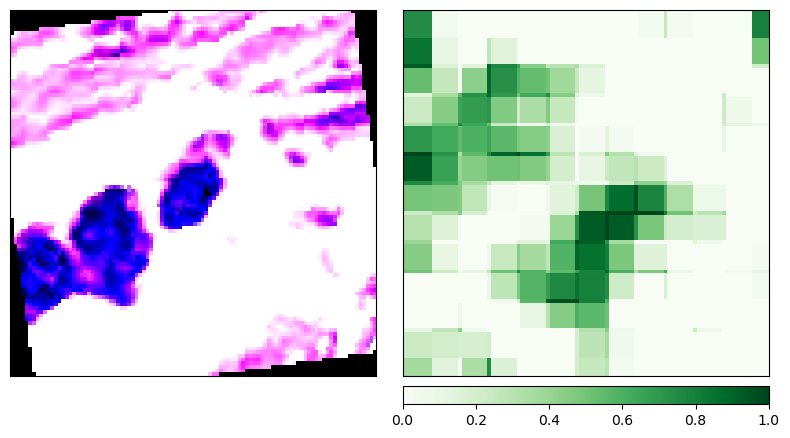

In [40]:
 with torch.no_grad():
        for data, target in testDataLoader:
            data, target = data.to(device), target.to(device)
            output = modelres(data)
            output = F.softmax(output, dim=1)
   #         _, pred = torch.max(output.data, 1)
            prediction_score, pred_label_idx = torch.topk(output, 1)

            pred_label_idx.squeeze_()
    #        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
            
            print("Integrated Gradients")
            print("\n")
            integrated_gradients = IntegratedGradients(modelres)
            attributions_ig = integrated_gradients.attribute(data, target=pred_label_idx, n_steps=200)
            
            default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
            _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(data.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
            print("Noise Tunnel")
            print("\n")
            noise_tunnel = NoiseTunnel(integrated_gradients)

            attributions_ig_nt = noise_tunnel.attribute(data, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
            _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(data.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
            
            torch.manual_seed(0)
            np.random.seed(0)
            
            print("Gradient Shap")
            print("\n")
            gradient_shap = GradientShap(modelres)

            # Defining baseline distribution of images
            rand_img_dist = torch.cat([data * 0, data * 1])
            
            attributions_gs = gradient_shap.attribute(data,
                                                      n_samples=50,
                                                      stdevs=0.0001,
                                                      baselines=rand_img_dist,
                                                      target=pred_label_idx)
            _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                  np.transpose(data.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                  ["original_image", "heat_map"],
                                                  ["all", "absolute_value"],
                                                  cmap=default_cmap,
                                                  show_colorbar=True)
            print("Occlusion")
            print("\n")
            occlusion = Occlusion(modelres)

            attributions_occ = occlusion.attribute(data,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
            
            _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(data.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
            break
            
           

Looks like the resnet18 model is not able to work well with captum. The outputs are gibberish and incomprehensible.